In [1]:
"""
Allegra Marsiglio
CS767 TERM PROJECT
"""

import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import glob
import tensorflow as tf
from tensorflow import keras
from collections import defaultdict

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Train data

In [3]:
## LOAD IMAGES

# Initialize a dictionary to store the images with filenames as keys
images_train = {}
images_folder_path = '/content/drive/MyDrive/train/'

# Load the images from the 'train' folder using OpenCV and store them in the dictionary
for file_path in glob.glob(images_folder_path + '*.jpg'):
    file_name = file_path.split('/')[-1]  # Extract the filename from the full path
    images_train[file_name] = cv2.imread(file_path)


In [4]:
# Load the annotations CSV file
annotations_path = '/content/drive/MyDrive/train_annotations.csv'
annotations_df = pd.read_csv(annotations_path)

# Define the classes (plastic, glass, metal)
classes = ['plastic', 'glass', 'metal']

# Define the number of bounding boxes to predict per image
num_boxes = 5

def convert_to_output_format(annotations_df, classes, num_boxes):
    image_dict = {}

    for _, row in annotations_df.iterrows():
        filename = row['filename']
        class_name = row['class']
        xmin = row['xmin']
        ymin = row['ymin']
        xmax = row['xmax']
        ymax = row['ymax']
        width = row['width']
        height = row['height']

        # Normalize bounding box coordinates
        bx = xmin / width
        by = ymin / height
        bw = (xmax - xmin) / width
        bh = (ymax - ymin) / height

        if filename not in image_dict:
            # Initialize entry for the filename
            image_dict[filename] = {
                'class_probs': np.zeros((num_boxes, len(classes))),
                'boxes': np.zeros((num_boxes, 4))
            }

        # Find an available slot to store the bounding box information
        for box_idx in range(num_boxes):
            if np.sum(image_dict[filename]['class_probs'][box_idx]) == 0:
                class_idx = classes.index(class_name)
                image_dict[filename]['class_probs'][box_idx, class_idx] = 1.0
                image_dict[filename]['boxes'][box_idx] = [bx, by, bw, bh]
                break

    return image_dict

# Convert the annotations to the desired output format
output_dict = convert_to_output_format(annotations_df, classes, num_boxes)

# Now, `output_dict` contains the predicted class scores and bounding box coordinates
# for each image in the format described earlier.


In [5]:
# Clean data from files that are in anotations but no images and vice versa
output_dict = {key: output_dict[key] for key in output_dict if key in images_train}
images_train = {key: images_train[key] for key in images_train if key in output_dict}

In [6]:
print(len(output_dict), len(images_train))

6075 6075


In [7]:
def preprocess_input_images(input_data):
    preprocessed_images = []
    for filename, image_data in input_data.items():
        img = image_data
        img = cv2.resize(img, (224, 224))
        img = img.astype(np.float32) / 255.0  # Normalize pixel values to [0, 1]
        preprocessed_images.append(img)

    preprocessed_images = np.array(preprocessed_images)
    return preprocessed_images

def preprocess_output_data(output_data):
    # Initialize arrays to hold the class probabilities and boxes
    max_detections = 5
    num_classes = 3
    class_probs_array = np.zeros((len(output_data), max_detections, num_classes))
    boxes_array = np.zeros((len(output_data), max_detections, 4))

    for i, filename in enumerate(output_data.keys()):
        class_probs = output_data[filename]['class_probs']
        boxes = output_data[filename]['boxes']

        # Store the class probabilities and boxes in the respective arrays
        num_detections = min(max_detections, len(class_probs))
        class_probs_array[i, :num_detections] = class_probs[:num_detections]
        boxes_array[i, :num_detections] = boxes[:num_detections]

    return class_probs_array, boxes_array

In [8]:
# Assuming you have 'input_data' and 'output_data' as your input and output data, respectively.
# Also, 'num_classes' should be set to the number of classes in your dataset.

# Preprocess input images
preprocessed_images_train = preprocess_input_images(images_train)

# Preprocess output data
class_probs_array_train, boxes_array_train = preprocess_output_data(output_dict)

# Train the VGG16-based object detection model
# Now you can use 'preprocessed_images' as input and 'class_probs_array' and 'boxes_array' as output for training the model.

# Validation data

In [9]:
## LOAD IMAGES

# Initialize a dictionary to store the images with filenames as keys
images_valid = {}
images_folder_path = '/content/drive/MyDrive/valid/'

# Load the images from the 'valid' folder using OpenCV and store them in the dictionary
for file_path in glob.glob(images_folder_path + '*.jpg'):
    file_name = file_path.split('/')[-1]  # Extract the filename from the full path
    images_valid[file_name] = cv2.imread(file_path)


In [10]:
# Load the annotations CSV file
annotations_path = '/content/drive/MyDrive/valid_annotations.csv'
annotations_df = pd.read_csv(annotations_path)

# Define the classes (plastic, glass, metal)
classes = ['plastic', 'glass', 'metal']

# Define the number of bounding boxes to predict per image
num_boxes = 5

def convert_to_output_format(annotations_df, classes, num_boxes):
    image_dict = {}

    for _, row in annotations_df.iterrows():
        filename = row['filename']
        class_name = row['class']
        xmin = row['xmin']
        ymin = row['ymin']
        xmax = row['xmax']
        ymax = row['ymax']
        width = row['width']
        height = row['height']

        # Normalize bounding box coordinates
        bx = xmin / width
        by = ymin / height
        bw = (xmax - xmin) / width
        bh = (ymax - ymin) / height

        if filename not in image_dict:
            # Initialize entry for the filename
            image_dict[filename] = {
                'class_probs': np.zeros((num_boxes, len(classes))),
                'boxes': np.zeros((num_boxes, 4))
            }

        # Find an available slot to store the bounding box information
        for box_idx in range(num_boxes):
            if np.sum(image_dict[filename]['class_probs'][box_idx]) == 0:
                class_idx = classes.index(class_name)
                image_dict[filename]['class_probs'][box_idx, class_idx] = 1.0
                image_dict[filename]['boxes'][box_idx] = [bx, by, bw, bh]
                break

    return image_dict

# Convert the annotations to the desired output format
output_dict = convert_to_output_format(annotations_df, classes, num_boxes)

# Now, `output_dict` contains the predicted class scores and bounding box coordinates
# for each image in the format described earlier.


In [11]:
# Clean data from files that are in anotations but no images and vice versa
output_dict = {key: output_dict[key] for key in output_dict if key in images_valid}
images_valid = {key: images_valid[key] for key in images_valid if key in output_dict}

In [12]:
print(len(output_dict), len(images_valid))

1953 1953


In [13]:
def preprocess_input_images(input_data):
    preprocessed_images = []
    for filename, image_data in input_data.items():
        img = image_data
        img = cv2.resize(img, (224, 224))
        img = img.astype(np.float32) / 255.0  # Normalize pixel values to [0, 1]
        preprocessed_images.append(img)

    preprocessed_images = np.array(preprocessed_images)
    return preprocessed_images

def preprocess_output_data(output_data):
    # Initialize arrays to hold the class probabilities and boxes
    max_detections = 5
    num_classes = 3
    class_probs_array = np.zeros((len(output_data), max_detections, num_classes))
    boxes_array = np.zeros((len(output_data), max_detections, 4))

    for i, filename in enumerate(output_data.keys()):
        class_probs = output_data[filename]['class_probs']
        boxes = output_data[filename]['boxes']

        # Store the class probabilities and boxes in the respective arrays
        num_detections = min(max_detections, len(class_probs))
        class_probs_array[i, :num_detections] = class_probs[:num_detections]
        boxes_array[i, :num_detections] = boxes[:num_detections]

    return class_probs_array, boxes_array

In [14]:
# Assuming you have 'input_data' and 'output_data' as your input and output data, respectively.
# Also, 'num_classes' should be set to the number of classes in your dataset.

# Preprocess input images
preprocessed_images_valid = preprocess_input_images(images_valid)

# Preprocess output data
class_probs_array_valid, boxes_array_valid = preprocess_output_data(output_dict)



# Model

In [15]:
from keras.applications import VGG16
from keras.layers import Flatten, Dense, Dropout, Input, RepeatVector
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import mean_squared_error, categorical_crossentropy, binary_crossentropy
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
import tensorflow_ranking as tfr

num_classes = 3
num_boxes = 5

# Load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Freeze all VGG layers so they will *not* be updated during the training process
vgg.trainable = False

# Flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

# Construct a fully-connected layer header to output the predicted bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = RepeatVector(num_boxes)(bboxHead)
bboxHead = Dense(4, activation="sigmoid", name="regression")(bboxHead)

# Construct a second fully-connected layer head, this one to predict the class label
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = RepeatVector(num_boxes)(softmaxHead)
softmaxHead = Dense(num_classes, activation="softmax", name="classification")(softmaxHead)

# Number of classes in your classification task (modify this based on your dataset)
num_classes = 3

# Put together our model which accepts an input image and then outputs
# bounding box coordinates and a class label
model = Model(inputs=vgg.input, outputs=[bboxHead, softmaxHead])

# Create a mask to ignore empty boxes during loss calculation
# Calculate the number of non-empty boxes for each sample
num_non_empty_boxes = np.sum(np.any(class_probs_array_train != 0, axis=-1), axis=1)
num_objects_per_image_train = num_non_empty_boxes.tolist()
mask_train = np.zeros((len(num_objects_per_image_train), num_boxes))
for i, num_objects in enumerate(num_objects_per_image_train):
    mask_train[i, :num_objects] = 1

from keras import backend as K


def custom_classification_loss(y_true, y_pred):
    # Apply a mask to ignore loss for empty boxes
    mask = tf.reduce_sum(y_true, axis=-1) > 0
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)

    # Calculate categorical cross-entropy loss
    loss = tf.keras.losses.categorical_crossentropy(y_true_masked, y_pred_masked)
    return loss


def custom_regression_loss(y_true, y_pred):
    # Apply a mask to ignore loss for empty boxes
    mask = tf.reduce_sum(y_true, axis=-1) > 0
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)

    # Calculate mean squared error loss for non-empty boxes
    loss = tf.keras.losses.mean_squared_error(y_true_masked, y_pred_masked)
    return loss


metric = tfr.keras.metrics.MeanAveragePrecisionMetric(name="mean_average_precision")


def mean_average_precision(y_true, y_pred):
    # Apply a mask to ignore loss for empty boxes
    mask = tf.reduce_sum(y_true, axis=-1) > 0
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)

    # transform y_pred into 1 or 0 depending on which class has the highest probability
    max_indices = tf.argmax(y_pred_masked, axis=1)
    y_pred_masked = tf.one_hot(max_indices, depth=y_pred_masked.shape[1])

    return metric(y_true_masked, y_pred_masked)


def custom_regression_metric(y_true, y_pred):
    # Apply a mask to ignore loss for empty boxes
    mask = tf.reduce_sum(y_true, axis=-1) > 0
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)

    # Calculate mean squared error loss for non-empty boxes
    loss = tf.keras.metrics.mean_squared_error(y_true_masked, y_pred_masked)
    return loss


# Add callbacks: checkpoint and early stopping
early_stopping = EarlyStopping(monitor='classification_mean_average_precision', min_delta=0, patience=20, verbose=1, mode='auto')
lr_scheduler = LearningRateScheduler(exponential_decay)

# Compile the model
# model.compile(optimizer=Adam(learning_rate=0.00000001), loss=losses, metrics=['accuracy'], loss_weights=loss_weights)
model.compile(optimizer=Adam(learning_rate=0.00000001),
              loss={'regression': custom_regression_loss, 'classification': custom_classification_loss},
              metrics={'regression': custom_regression_metric, 'classification': mean_average_precision})

# Start the training process
history = model.fit(preprocessed_images_train, {'regression': boxes_array_train, 'classification': class_probs_array_train},
                    validation_data = [preprocessed_images_valid, {'regression': boxes_array_valid, 'classification': class_probs_array_valid}],
                    batch_size=32, epochs=5, callbacks=[early_stopping])


Epoch 1/5
190/190 [==============================] - 58s 213ms/step - loss: 1.4681 - regression_loss: 0.0736 - classification_loss: 1.3945 - regression_custom_regression_metric: 0.0737 - classification_mean_average_precision: 0.6312 - val_loss: 1.1983 - val_regression_loss: 0.0730 - val_classification_loss: 1.1253 - val_regression_custom_regression_metric: 0.0732 - val_classification_mean_average_precision: 0.6326
Epoch 2/5
190/190 [==============================] - 36s 188ms/step - loss: 1.4728 - regression_loss: 0.0731 - classification_loss: 1.3997 - regression_custom_regression_metric: 0.0731 - classification_mean_average_precision: 0.6328 - val_loss: 1.1941 - val_regression_loss: 0.0725 - val_classification_loss: 1.1217 - val_regression_custom_regression_metric: 0.0726 - val_classification_mean_average_precision: 0.6322
Epoch 3/5
190/190 [==============================] - 36s 188ms/step - loss: 1.4651 - regression_loss: 0.0727 - classification_loss: 1.3924 - regression_custom_regre

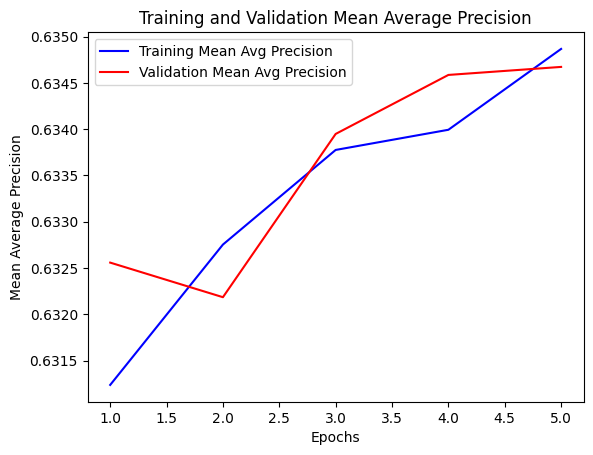

In [16]:
import matplotlib.pyplot as plt

# Get the average precision values for training and validation
train_avg_precision = history.history['classification_mean_average_precision']
val_avg_precision = history.history['val_classification_mean_average_precision']

# Plot the average precision values
epochs = range(1, len(train_avg_precision) + 1)

plt.plot(epochs, train_avg_precision, 'b', label='Training Mean Avg Precision')
plt.plot(epochs, val_avg_precision, 'r', label='Validation Mean Avg Precision')
plt.title('Training and Validation Mean Average Precision')
plt.xlabel('Epochs')
plt.ylabel('Mean Average Precision')
plt.legend()
plt.show()
